## <u>Time Series Forecasting of Website Event Count: Predicting Total Events Over Time</u>


### Project Owner: Manuel Contreras

Dataset: https://statso.io/website-performance-case-study/

### 1 - Libraries

##### Data manipulation and numerical computing

In [158]:
import pandas as pd
import numpy as np

##### Visualization tools

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

##### Machine learning

In [160]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

##### Time series analysis

In [161]:
from prophet import Prophet

### 2 - Dataset Import and Feature Computation

In [162]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [163]:
file_path = r"C:\Users\manue\Desktop\DataScience\Datasets\web_traffic.csv"

df = pd.read_csv(file_path, header=1)

df.head()

,Session primary channel group (Default channel group),Date + hour (YYYYMMDDHH),Users,Sessions,Engaged sessions,Average engagement time per session,Engaged sessions per user,Events per session,Engagement rate,Event count
0,Direct,2024041623,237,300,144,47.526667,0.607595,4.673333,0.480000,1402
1,Organic Social,2024041719,208,267,132,32.097378,0.634615,4.295880,0.494382,1147
2,Direct,2024041723,188,233,115,39.939914,0.611702,4.587983,0.493562,1069
3,Organic Social,2024041718,187,256,125,32.160156,0.668449,4.078125,0.488281,1044
4,Organic Social,2024041720,175,221,112,46.918552,0.640000,4.529412,0.506787,1001


In [164]:
rows, columns = df.shape
print(f"The dataset has {columns} columns and {rows} rows.")

The dataset has 10 columns and 3182 rows.


### 3 - Data Cleaning

#### Null Values Processing

In [165]:
# missing values in each column
missing_counts = df.isnull().sum()
missing_counts

Session primary channel group (Default channel group)    0
Date + hour (YYYYMMDDHH)                                 0
Users                                                    0
Sessions                                                 0
Engaged sessions                                         0
Average engagement time per session                      0
Engaged sessions per user                                0
Events per session                                       0
Engagement rate                                          0
Event count                                              0
dtype: int64

#### Elimination of Duplicates

In [166]:
# duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 0


### 4 - Data Preparation for Time Series Analysis

#### Data Type Conversion and Index Setting

In [167]:
# To reduce the scope of the analysis, I will concentrate on the number of events per hour, independently of the channel group and all the other variables. 

df= df[['Date + hour (YYYYMMDDHH)', 'Event count']]

In [168]:
# Check the datatype of the "Date + hour (YYYYMMDDHH)" column
print(df['Date + hour (YYYYMMDDHH)'].dtype)

int64


In [169]:
# "Date + hour (YYYYMMDDHH)" has to have a datetime format
df['Date + hour (YYYYMMDDHH)'] = pd.to_datetime(df['Date + hour (YYYYMMDDHH)'].astype(str), format='%Y%m%d%H')

# Verify the conversion
print(df['Date + hour (YYYYMMDDHH)'].head())

0   2024-04-16 23:00:00
1   2024-04-17 19:00:00
2   2024-04-17 23:00:00
3   2024-04-17 18:00:00
4   2024-04-17 20:00:00
Name: Date + hour (YYYYMMDDHH), dtype: datetime64[ns]


The date variable should be set as the index of the df for the following reasons:

* Temporal Order: Setting the date as the index ensures that the data remains ordered by time, which is crucial for analyzing trends, seasonality, and patterns over time.

* Efficient Time-Based Operations: Pandas provides powerful time-based functionality (like resampling, rolling windows, shifting, and slicing by date) that relies on the index being a datetime object. These operations are easier and faster when the date is set as the index.

* Alignment and Interpolation: When performing operations such as merging, aligning data, or interpolating missing values, having the date as the index ensures that data aligns correctly in terms of time.

* Handling Gaps and Resampling: In many cases, you may want to fill missing data points, resample to a different frequency (e.g., daily to monthly), or calculate moving averages. These operations are simplified when the date is the index.

* Modeling: Many time series models (e.g., ARIMA, Prophet) require a well-defined temporal index to make accurate predictions. Having the date as the index provides the models with the temporal structure needed to understand dependencies between time periods.

In [170]:
# Set the "Date + hour (YYYYMMDDHH)" as the index
df.set_index('Date + hour (YYYYMMDDHH)', inplace=True)

In [171]:
# Df should be sorted by date
df.sort_index(inplace=True)

df.head(60)


,Event count
Date + hour (YYYYMMDDHH),
2024-04-06 00:00:00,2
2024-04-06 00:00:00,266
2024-04-06 00:00:00,151
2024-04-06 00:00:00,421
2024-04-06 00:00:00,238
2024-04-06 01:00:00,214
2024-04-06 01:00:00,148
2024-04-06 01:00:00,93
2024-04-06 01:00:00,219


In [172]:
# Group by 'Date + hour (YYYYMMDDHH)' and sum the 'Event count'
df = df.groupby('Date + hour (YYYYMMDDHH)').agg({'Event count': 'sum'}).reset_index()

In [173]:
df.head()

,Date + hour (YYYYMMDDHH),Event count
0,2024-04-06 00:00:00,1078
1,2024-04-06 01:00:00,674
2,2024-04-06 02:00:00,725
3,2024-04-06 03:00:00,606
4,2024-04-06 04:00:00,486


#### Outlier Detection

In [174]:
# A good way to identify outliers is by plotting

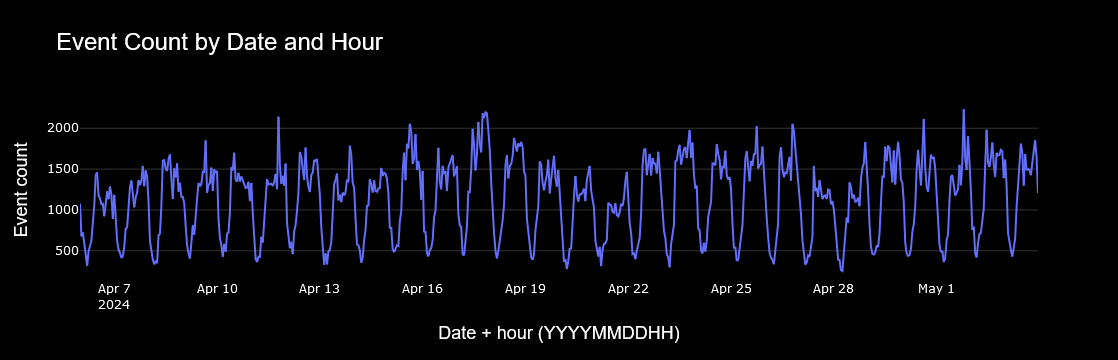

In [175]:
# set 'Date + hour (YYYYMMDDHH)' as a datetime object
df['Date + hour (YYYYMMDDHH)'] = pd.to_datetime(df['Date + hour (YYYYMMDDHH)'], format='%Y%m%d%H')

# Set 'Date + hour (YYYYMMDDHH)' as the index
df.set_index('Date + hour (YYYYMMDDHH)', inplace=True)


event_count_by_date = df.resample('h').sum()  


if 'Event count' in event_count_by_date.columns:
    fig = px.line(
        event_count_by_date,
        x=event_count_by_date.index,
        y='Event count',
        title='Event Count by Date and Hour',
        labels={'x': 'Date + Hour', 'y': 'Event Count'},
        markers=False,  
        line_shape='linear'  
    )
    
    
    fig.update_layout(
        title_font=dict(size=24, family='Arial, sans-serif'),  
        xaxis_title_font=dict(size=18, family='Arial, sans-serif'),  
        yaxis_title_font=dict(size=18, family='Arial, sans-serif'),  
        xaxis=dict(showgrid=False),  
        yaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.2)'),  
        plot_bgcolor='black',  
        paper_bgcolor='black',  
        font_color='white',  
        legend=dict(
            title='',
            font=dict(size=12),
            bgcolor='rgba(0, 0, 0, 0.7)',  
            bordercolor='white',
            borderwidth=1
        )
    )
    
    
    fig.show()
else:
    print("The 'Event count' column does not exist in the aggregated data.")

No big outliers are to be seen

#### Feature Creation

In [176]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = create_features(df)

If there was data over a period of years, it would be possible to create more extensive features that could add more insights to the analysis, such as quarter, month, year, etc. Unfortunarely, it is not the case.

In [177]:
df.head()

,Event count,hour,dayofweek
Date + hour (YYYYMMDDHH),,,
2024-04-06 00:00:00,1078,0,5
2024-04-06 01:00:00,674,1,5
2024-04-06 02:00:00,725,2,5
2024-04-06 03:00:00,606,3,5
2024-04-06 04:00:00,486,4,5


### 
4 - Exploratory Data Analysis

#### Event Count by Hour

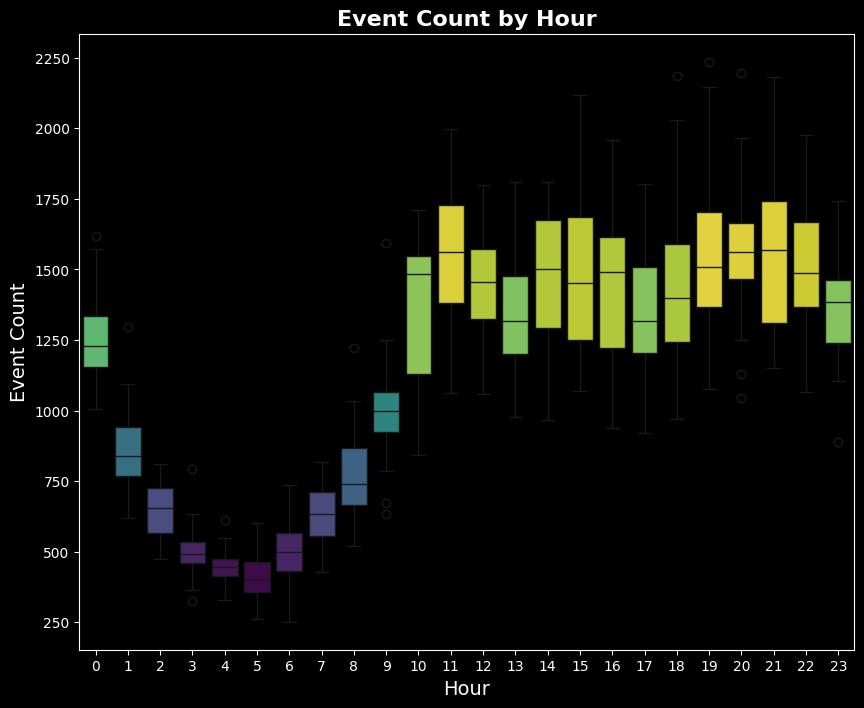

In [178]:
# Get unique hour values
unique_hours = df['hour'].unique()

# Calculate the average Event count per hour
grouped = df.groupby('hour')['Event count'].mean()

# Normalize the average Event count values
norm = plt.Normalize(grouped.min(), grouped.max())

# Create a color palette based on the normalized values using a colormap
colors = plt.cm.viridis(norm(grouped))

# Convert the colors to hex codes
hex_colors = [mcolors.to_hex(c) for c in colors]

# Ensure that all unique hour values are in the palette
palette = {hour: color for hour, color in zip(grouped.index, hex_colors)}

# Set dark theme and create figure
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))

# Assign the hour variable to hue to ensure palette works correctly
sns.boxplot(data=df, x='hour', y='Event count', hue='hour', palette=palette, dodge=False, ax=ax, legend=False)

# Customize title and axis labels
ax.set_title('Event Count by Hour', fontsize=16, fontweight='bold', color='white')
ax.set_xlabel('Hour', fontsize=14, color='white')
ax.set_ylabel('Event Count', fontsize=14, color='white')

# Remove gridlines
ax.grid(False)

# Show the plot
plt.show()

As expected, there is a valley late at night in website traffic, when most people are sleeping, while the ups are between 19 and 21, when people are out of work.

#### Event count by Day of the Week

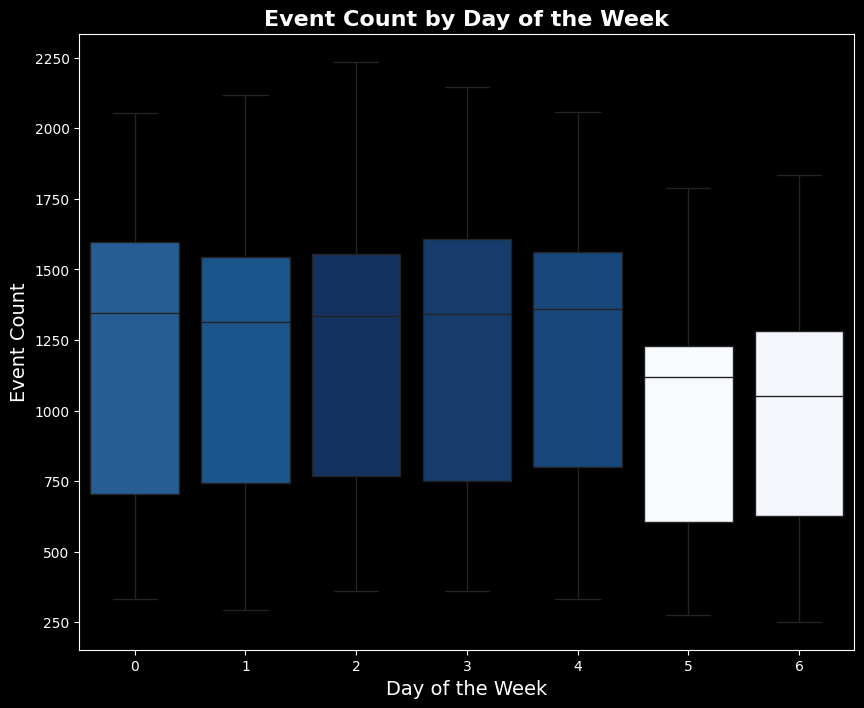

In [180]:
# Get unique day of the week values
unique_days = df['dayofweek'].unique()

# average Event count per day of the week
grouped = df.groupby('dayofweek')['Event count'].mean()

# average Event count values normalization
norm = plt.Normalize(grouped.min(), grouped.max())

# color palette based on the normalized values using a colormap
colors = plt.cm.Blues(norm(grouped))

# colors to hex codes
hex_colors = [mcolors.to_hex(c) for c in colors]

# all unique dayofweek values are in the palette
palette = {day: color for day, color in zip(grouped.index, hex_colors)}

# dark theme and create figure
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))

# Assign the dayofweek variable to hue to ensure palette works correctly
sns.boxplot(data=df, x='dayofweek', y='Event count', hue='dayofweek', palette=palette, dodge=False, ax=ax, legend=False)

# title and axis labels
ax.set_title('Event Count by Day of the Week', fontsize=16, fontweight='bold', color='white')
ax.set_xlabel('Day of the Week', fontsize=14, color='white')
ax.set_ylabel('Event Count', fontsize=14, color='white')

# Remove gridlines
ax.grid(False)

# plot
plt.show()

## 5 - Model Creation

## 5.0 - XGBoost

#### Train Test Split

In [181]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*4, gap=8)
df = df.sort_index()

# df needs to be sorted, otherwise the time series split wont work

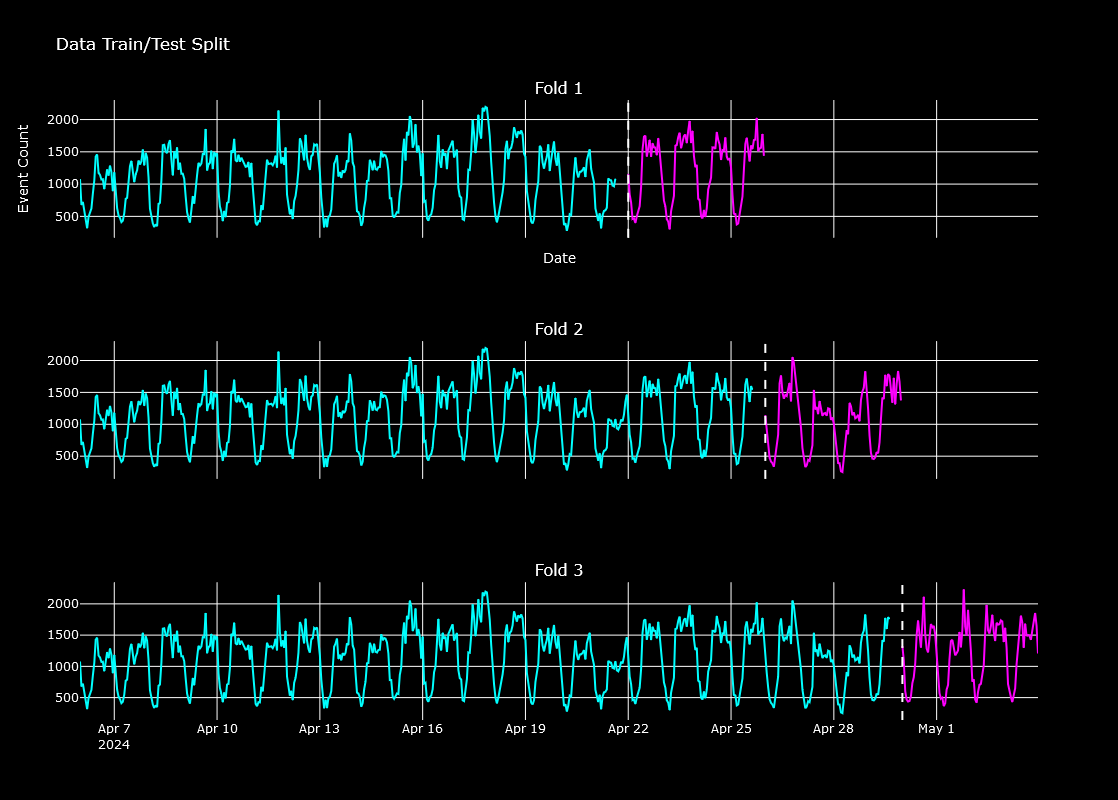

In [182]:
fold = 0
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=[f'Fold {i+1}' for i in range(3)])

# olors
train_color = 'cyan'
test_color = 'magenta'
split_line_color = 'white'

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    # Add training set trace
    fig.add_trace(
        go.Scatter(
            x=train.index,
            y=train['Event count'],
            mode='lines',
            line=dict(color=train_color, width=2),
            hoverinfo='text',
            text='Training Set'
        ),
        row=fold + 1,
        col=1
    )
    
    # Add test set trace
    fig.add_trace(
        go.Scatter(
            x=test.index,
            y=test['Event count'],
            mode='lines',
            line=dict(color=test_color, width=2),
            hoverinfo='text',
            text='Test Set'
        ),
        row=fold + 1,
        col=1
    )
    
    # Add vertical line for test set start
    fig.add_vline(x=test.index.min(), line_color=split_line_color, line_dash='dash', row=fold + 1, col=1)
    
    fold += 1

# Update layout for aesthetics
fig.update_layout(
    title='Data Train/Test Split',
    height=800,
    plot_bgcolor='black',  
    paper_bgcolor='black',  
    font=dict(color='white'),  
    xaxis_title='Date',
    yaxis_title='Event Count',
    showlegend=False  
)

# Show the plot
fig.show()

In [183]:
# time series split 
tss = TimeSeriesSplit(n_splits=3, test_size=24 * 4, gap=8)

# predictions and scores
preds = []
scores = []

# parameter grid for tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 500],
}

In [184]:
for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Create features for both training and testing datasets
    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek']
    TARGET = 'Event count'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # XGBoost regressor
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', objective='reg:squarederror')

    # GridSearchCV 
    grid_search = GridSearchCV(estimator=reg, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=3, verbose=100, n_jobs=-1)

    # Fit the model 
    grid_search.fit(X_train, y_train)

    # best estimator from GridSearchCV
    best_reg = grid_search.best_estimator_

    # Fit the best model on the training data
    best_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    # predictions on the test set
    y_pred = best_reg.predict(X_test)
    preds.append(y_pred)

    # RMSE and store it
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:1193.62190	validation_1-rmse:1307.21244
[100]	validation_0-rmse:476.20296	validation_1-rmse:536.76649
[200]	validation_0-rmse:240.76577	validation_1-rmse:267.00308
[300]	validation_0-rmse:180.17292	validation_1-rmse:188.63835
[400]	validation_0-rmse:166.13615	validation_1-rmse:169.18489
[499]	validation_0-rmse:159.89637	validation_1-rmse:167.65317
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:1207.24152	validation_1-rmse:1176.60578
[100]	validation_0-rmse:478.11430	validation_1-rmse:470.33577
[200]	validation_0-rmse:238.97496	validation_1-rmse:241.04053
[300]	validation_0-rmse:178.96365	validation_1-rmse:181.27336
[400]	validation_0-rmse:165.98529	validation_1-rmse:167.77926
[499]	validation_0-rmse:161.59484	validation_1-rmse:164.79366
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:1203.85888	validation_1-rmse:1306.88306
[100]	valid

In [185]:
print(f'Best parameters: {grid_search.best_params_}')
print(f'RMSE scores: {scores}')
print(f'Score across folds {np.mean(scores):0.4f}')

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
RMSE scores: [167.65316822440352, 164.7936579480238, 179.30239595884385]
Score across folds 170.5831


#### Future Prediction

In [186]:
X = df[['hour', 'dayofweek']]
y = df['Event count']

In [187]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

In [188]:
reg.fit(X, y,
        eval_set=[(X, y)],
        verbose=100)

[0]	validation_0-rmse:1223.73566
[100]	validation_0-rmse:482.39180
[200]	validation_0-rmse:240.18678
[300]	validation_0-rmse:179.94964
[400]	validation_0-rmse:167.05180
[499]	validation_0-rmse:162.92379


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [189]:
df.index.max()

Timestamp('2024-05-03 23:00:00')

In [190]:
# future dataframe
future = pd.date_range('2024-05-03 23:00:00','2024-06-03 23:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [191]:
future_w_features = df_and_future.query('isFuture').copy()

In [192]:
future_w_features

,Event count,hour,dayofweek,isFuture
2024-05-03 23:00:00,NaN,23,4,True
2024-05-04 00:00:00,NaN,0,5,True
2024-05-04 01:00:00,NaN,1,5,True
2024-05-04 02:00:00,NaN,2,5,True
2024-05-04 03:00:00,NaN,3,5,True
...,...,...,...,...
2024-06-03 19:00:00,NaN,19,0,True
2024-06-03 20:00:00,NaN,20,0,True
2024-06-03 21:00:00,NaN,21,0,True
2024-06-03 22:00:00,NaN,22,0,True


In [193]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

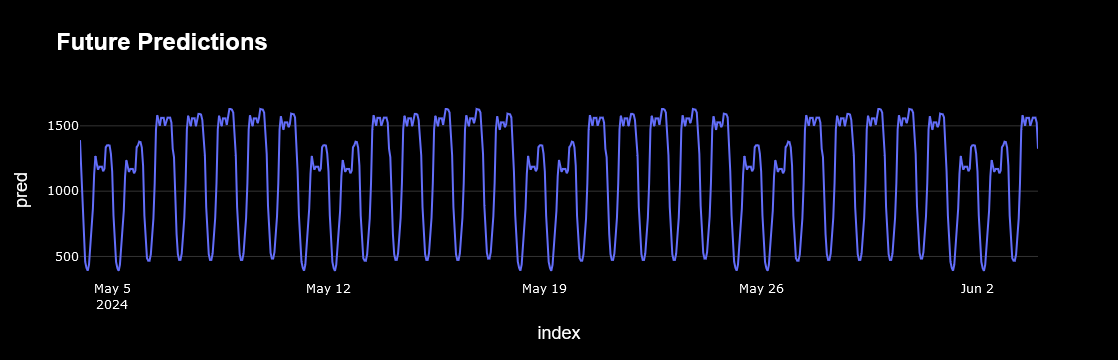

In [194]:
# plot
fig = px.line(
    future_w_features,
    x=future_w_features.index,
    y='pred',
    title='Future Predictions',
    labels={'x': 'Date + Hour', 'y': 'Predicted Events'},
    line_shape='linear'
)

# layout 
fig.update_layout(
    title_font=dict(size=24, family='Arial, sans-serif', weight='bold'),
    xaxis_title_font=dict(size=18, family='Arial, sans-serif'),
    yaxis_title_font=dict(size=18, family='Arial, sans-serif'),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.2)'),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white'
)

# Show the plot
fig.show()

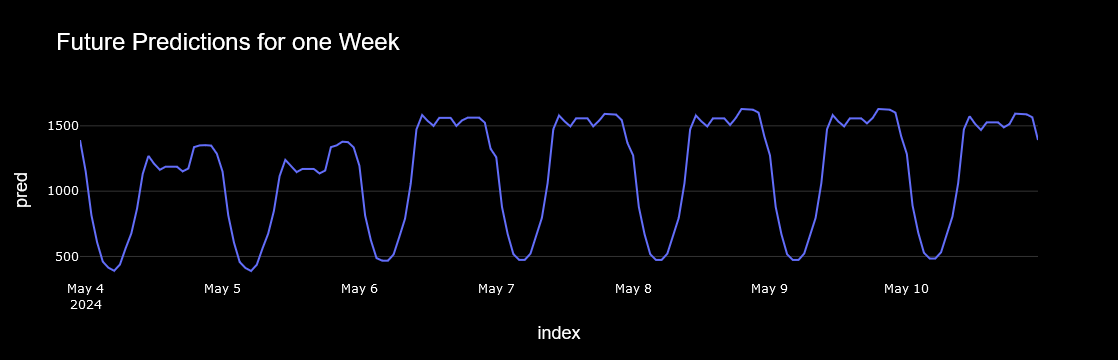

In [195]:
# date range
start_date = '2024-05-03 23:00:00'
end_date = '2024-05-10 23:00:00'

# Filter the DataFrame for the specified date range
filtered_data = future_w_features.loc[start_date:end_date]

# line plot
fig = px.line(
    filtered_data,
    x=filtered_data.index,
    y='pred',
    title='Future Predictions for one Week',
    labels={'x': 'Date + Hour', 'y': 'Predicted Events'},
    markers=False,
    line_shape='linear'
)


fig.update_layout(
    title_font=dict(size=24, family='Arial, sans-serif'),
    xaxis_title_font=dict(size=18, family='Arial, sans-serif'),
    yaxis_title_font=dict(size=18, family='Arial, sans-serif'),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.2)'),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    legend=dict(
        title='',
        font=dict(size=12),
        bgcolor='rgba(0, 0, 0, 0.7)',
        bordercolor='white',
        borderwidth=1
    )
)

# Show the plot
fig.show()

#### Metrics Computation

In [196]:
pred = reg.predict(X_test)

In [197]:
pred

array([1259.7727 ,  879.6652 ,  671.50464,  517.7021 ,  473.9353 ,
        473.9353 ,  522.2637 ,  656.4178 ,  795.6992 , 1060.4646 ,
       1474.0355 , 1579.035  , 1533.0536 , 1496.1105 , 1557.436  ,
       1557.436  , 1557.436  , 1496.0709 , 1538.0121 , 1591.364  ,
       1591.364  , 1586.2496 , 1544.0933 , 1369.019  , 1273.4299 ,
        879.29486,  671.1343 ,  517.3317 ,  473.5649 ,  473.5649 ,
        521.8933 ,  656.0474 ,  795.32886, 1060.0942 , 1473.6652 ,
       1578.6647 , 1532.6832 , 1495.7401 , 1557.0657 , 1557.0657 ,
       1557.0657 , 1506.3762 , 1559.8206 , 1628.8904 , 1628.8904 ,
       1623.776  , 1601.0571 , 1420.7053 , 1273.4299 ,  879.29486,
        671.1343 ,  517.3317 ,  473.5649 ,  473.5649 ,  521.8933 ,
        656.0474 ,  795.32886, 1060.0942 , 1473.6652 , 1581.8196 ,
       1532.6832 , 1495.7401 , 1557.0657 , 1557.0657 , 1557.0657 ,
       1518.8788 , 1559.8206 , 1628.8904 , 1628.8904 , 1623.776  ,
       1601.0571 , 1420.7053 , 1283.9407 ,  889.8059 ,  681.64

In [198]:
mae1 = mean_absolute_error(y_test, pred)
mae1

123.45700645446777

In [199]:
mape1 = mean_absolute_percentage_error(y_test, pred)
mape1

0.1038819807438055

In [200]:
# Store of results
results_df = pd.DataFrame(columns=['Model', 'Mean Absolute Error', 'Mean Absolute Percentage Error' ])
new_row = pd.DataFrame([{'Model': 'XGBoost', 'Mean Absolute Error': mae1, 'Mean Absolute Percentage Error' : mape1}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df.head()

,Model,Mean Absolute Error,Mean Absolute Percentage Error
0,XGBoost,123.457006,0.103882


## 5.1 - XGBoost with Lag Features

Lag features in time series analysis refer to the values of a time series data point at previous time steps. They are crucial for capturing the temporal dependencies and patterns within the data, allowing predictive models to leverage past information to forecast future values. A lag feature is created by shifting the time series data backward by a certain number of time steps.

Lag Features are great when the dataset is robust. In this case, the dataset only has information of a little more a month, so I can only go back in time a few days in order not to get rid of a lot of the original data, which is not ideal.

In [201]:
def add_lags(df):
    target_map = df['Event count'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('6 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('9 days')).map(target_map)
    return df

In [202]:
df_lags = add_lags(df)
df_lags

,Event count,hour,dayofweek,isFuture,lag1,lag2,lag3
Date + hour (YYYYMMDDHH),,,,,,,
2024-04-06 00:00:00,1078,0,5,False,NaN,NaN,NaN
2024-04-06 01:00:00,674,1,5,False,NaN,NaN,NaN
2024-04-06 02:00:00,725,2,5,False,NaN,NaN,NaN
2024-04-06 03:00:00,606,3,5,False,NaN,NaN,NaN
2024-04-06 04:00:00,486,4,5,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-05-03 19:00:00,1572,19,4,False,1480.0,1132.0,1522.0
2024-05-03 20:00:00,1749,20,4,False,1679.0,1250.0,1727.0
2024-05-03 21:00:00,1855,21,4,False,1624.0,1241.0,1424.0


I keep the same parameters that were determined by the GridSearch before

In [203]:
X = df_lags[['hour', 'dayofweek','lag1','lag2','lag3']]
y = df_lags['Event count']

In [204]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

In [205]:
df_lags.tail()

,Event count,hour,dayofweek,isFuture,lag1,lag2,lag3
Date + hour (YYYYMMDDHH),,,,,,,
2024-05-03 19:00:00,1572,19,4,False,1480.0,1132.0,1522.0
2024-05-03 20:00:00,1749,20,4,False,1679.0,1250.0,1727.0
2024-05-03 21:00:00,1855,21,4,False,1624.0,1241.0,1424.0
2024-05-03 22:00:00,1648,22,4,False,1650.0,1067.0,1370.0
2024-05-03 23:00:00,1206,23,4,False,1509.0,1110.0,1405.0


In [206]:
train_size = int(len(X) * 0.8)  
X_train = X[:train_size]         
X_test = X[train_size:]  
y_train = y[:train_size]         
y_test = y[train_size:] 

In [207]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [208]:
# Predict on the test set (X_test)
y_pred = reg.predict(X_test)

#### Metrics Computation

In [209]:
mae2 = mean_absolute_error(y_test, y_pred)
mae2

139.79843456127026

In [210]:
# Mean Absolute Percentage Error
mape2 = mean_absolute_percentage_error(y_test, y_pred)
mape2

0.11506637448983839

In [211]:
# Store of results
new_row = pd.DataFrame([{'Model': 'XGBoost with Lag Features', 'Mean Absolute Error': mae2, 'Mean Absolute Percentage Error' : mape2 }])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df.head()

,Model,Mean Absolute Error,Mean Absolute Percentage Error
0,XGBoost,123.457006,0.103882
1,XGBoost with Lag Features,139.798435,0.115066


## 5.2 - Prophet

Prophet is an open-source forecasting tool developed by Facebook designed for producing high-quality forecasts for time series data that may have strong seasonal effects and several seasons of historical data. 

In [212]:
split_date = pd.to_datetime('27-Apr-2024')
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [213]:
df_test.head()

,Event count,hour,dayofweek,isFuture,lag1,lag2,lag3
Date + hour (YYYYMMDDHH),,,,,,,
2024-04-27 01:00:00,944,1,5,False,772.0,624.0,1001.0
2024-04-27 02:00:00,628,2,5,False,753.0,545.0,715.0
2024-04-27 03:00:00,506,3,5,False,501.0,427.0,499.0
2024-04-27 04:00:00,328,4,5,False,466.0,550.0,405.0
2024-04-27 05:00:00,357,5,5,False,601.0,311.0,497.0


In [214]:
# Drop the specified columns from df_test

df_train = df_test.drop(columns=['isFuture', 'lag1', 'lag2', 'lag3'], errors='ignore').copy()
df_test = df_test.drop(columns=['isFuture', 'lag1', 'lag2', 'lag3'], errors='ignore').copy()

In [215]:
# The dataset has to be organized such as one variable is ds which represents the date and it has to have a date format, and y which is the dependent variable

df_train_p = df_train.reset_index() \
    .rename(columns={'Date + hour (YYYYMMDDHH)': 'ds',
                     'Event count': 'y'})

In [216]:
%%time
model = Prophet()
model.fit(df_train_p)

11:45:48 - cmdstanpy - INFO - Chain [1] start processing
11:45:49 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 125 ms
Wall time: 761 ms


In [217]:
# Predict on test set with model
df_test_p = df_test.reset_index() \
    .rename(columns={'Date + hour (YYYYMMDDHH)':'ds',
                     'Event count':'y'})

df_test_fcst = model.predict(df_test_p)

In [218]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-04-27 01:00:00,949.696280,494.285334,922.254084,949.696280,949.696280,-250.460450,-250.460450,-250.460450,-250.460450,-250.460450,-250.460450,0.0,0.0,0.0,699.235830
1,2024-04-27 02:00:00,952.574335,249.613424,686.961258,952.574335,952.574335,-476.464634,-476.464634,-476.464634,-476.464634,-476.464634,-476.464634,0.0,0.0,0.0,476.109701
2,2024-04-27 03:00:00,955.452391,123.378153,556.500251,955.452391,955.452391,-619.579609,-619.579609,-619.579609,-619.579609,-619.579609,-619.579609,0.0,0.0,0.0,335.872781
3,2024-04-27 04:00:00,958.330446,11.973382,481.517276,958.330446,958.330446,-697.294307,-697.294307,-697.294307,-697.294307,-697.294307,-697.294307,0.0,0.0,0.0,261.036139
4,2024-04-27 05:00:00,961.208501,28.363299,481.149459,961.208501,961.208501,-726.975414,-726.975414,-726.975414,-726.975414,-726.975414,-726.975414,0.0,0.0,0.0,234.233087


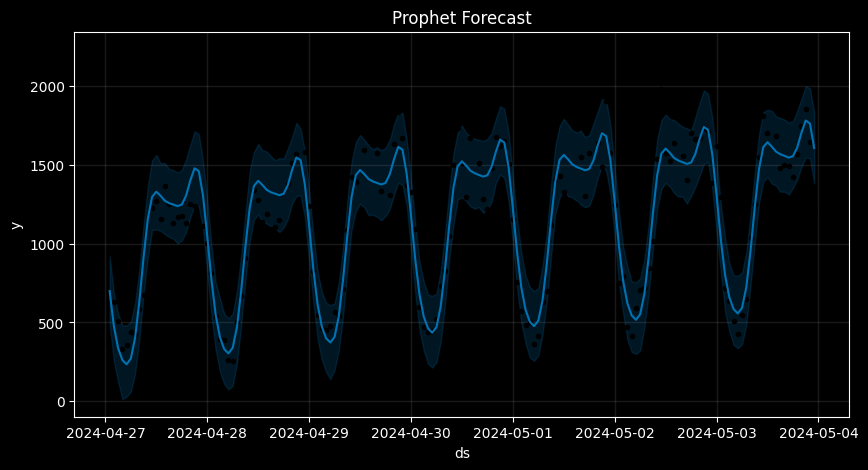

In [219]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

#### Plotting Results

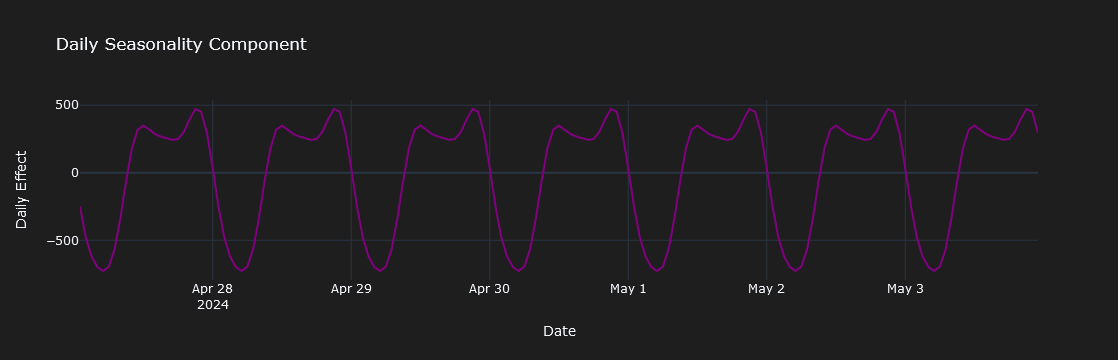

In [220]:
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df_test_fcst['ds'], 
    y=df_test_fcst['daily'], 
    mode='lines', 
    name='Daily Seasonality',
    line=dict(color='purple', width=2),
    hoverinfo='x+y',
    hoverlabel=dict(bgcolor='white', font_size=12, font_family="Arial")
))

# layout
fig.update_layout(
    title="Daily Seasonality Component",
    xaxis_title="Date",
    yaxis_title="Daily Effect",
    template="plotly_dark",  
    hovermode="x unified",   
    plot_bgcolor='#1e1e1e',  
    paper_bgcolor='#1e1e1e'
)


fig.show()

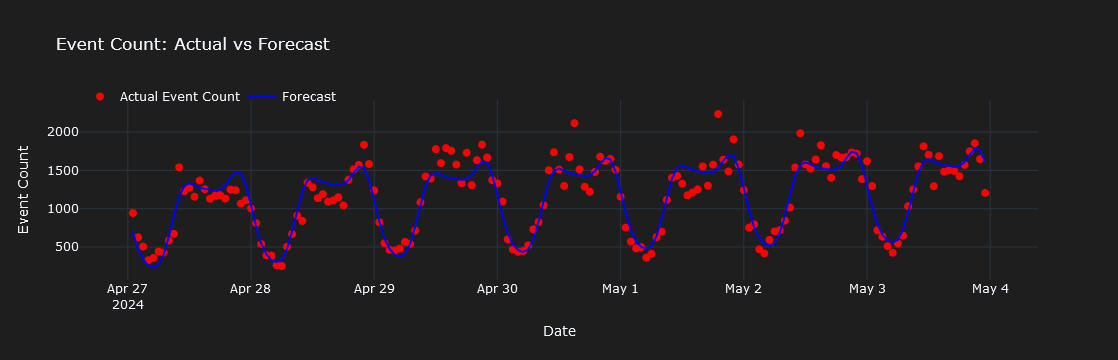

In [221]:
fig = go.Figure()

# Plot the actual event counts as red markers
fig.add_trace(go.Scatter(
    x=df_test.index, 
    y=df_test['Event count'], 
    mode='markers', 
    name='Actual Event Count',
    marker=dict(color='red', size=8),  # Red markers for actuals
    hoverinfo='x+y'
))

# Plot the forecast from the model
fig.add_trace(go.Scatter(
    x=df_test_fcst['ds'], 
    y=df_test_fcst['yhat'], 
    mode='lines', 
    name='Forecast',
    line=dict(color='blue', width=2),  # Blue line for forecast
    hoverinfo='x+y'
))

# layout 
fig.update_layout(
    title='Event Count: Actual vs Forecast',
    xaxis_title='Date',
    yaxis_title='Event Count',
    template='plotly_dark',  
    legend=dict(x=0, y=1.1, orientation='h', bgcolor='rgba(0,0,0,0)', font=dict(size=12)),
    hovermode='x unified',  
    plot_bgcolor='#1e1e1e',
    paper_bgcolor='#1e1e1e'
)

fig.show()

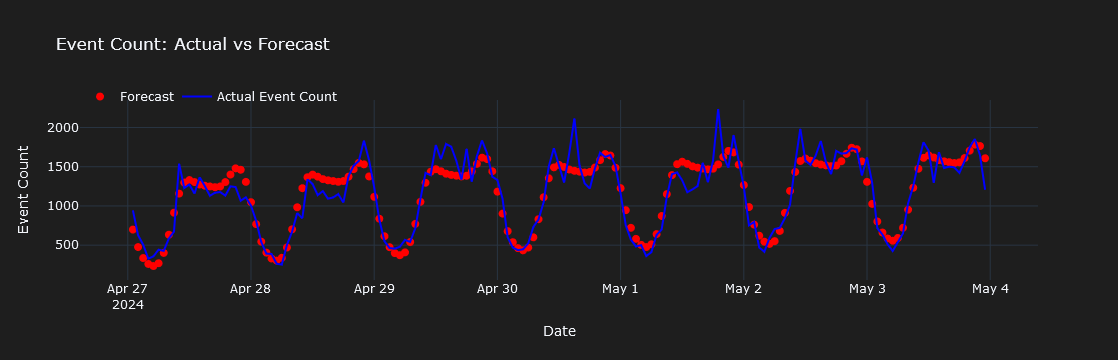

In [222]:
fig = go.Figure()

# Plot the actual event counts as red markers
fig.add_trace(go.Scatter(
    x=df_test_fcst['ds'], 
    y=df_test_fcst['yhat'],
    mode='markers', 
    name='Forecast',
    marker=dict(color='red', size=8),  # Red markers for actuals
    hoverinfo='x+y'
))

# Plot the forecast from the model
fig.add_trace(go.Scatter(
    x=df_test.index, 
    y=df_test['Event count'],  
    mode='lines', 
    name='Actual Event Count',
    line=dict(color='blue', width=2),  # Blue line for forecast
    hoverinfo='x+y'
))

# layout 
fig.update_layout(
    title='Event Count: Actual vs Forecast',
    xaxis_title='Date',
    yaxis_title='Event Count',
    template='plotly_dark',  
    legend=dict(x=0, y=1.1, orientation='h', bgcolor='rgba(0,0,0,0)', font=dict(size=12)),
    hovermode='x unified',  
    plot_bgcolor='#1e1e1e',
    paper_bgcolor='#1e1e1e'
)

fig.show()

Both graphs display the same data, but in the first one, the forecast is shown as a blue line, while the actual event count is represented by dots. In contrast, the second graph reverses this format.

The forecasted values clearly follow the same overall trend, though the line is smoother as it doesn't fully capture the spikes in the actual event count. However, the approximation is still very accurate.

#### Metrics Computation

In [223]:
mae3 = mean_absolute_error(y_true=df_test['Event count'], 
                          y_pred=df_test_fcst['yhat'])
mae3

129.199217412736

In [224]:
mape3 = mean_absolute_percentage_error(y_true=df_test['Event count'], 
                                      y_pred=df_test_fcst['yhat'])

mape3

0.12309351316937807

In [225]:
# Store of results
new_row = pd.DataFrame([{'Model': 'Prophet', 'Mean Absolute Error': mae3, 'Mean Absolute Percentage Error' : mape3}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df.head()

,Model,Mean Absolute Error,Mean Absolute Percentage Error
0,XGBoost,123.457006,0.103882
1,XGBoost with Lag Features,139.798435,0.115066
2,Prophet,129.199217,0.123094


## 7 - Best Model Selection

The three models achieved impressive results, each demonstrating a mean absolute error of less than 13%. Among them, **XGBoost** stood out as the top performer, with a **Mean Absolute Error** of **123.4** and a **Mean Absolute Percentage Error** of **0.103**.